In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint


In [2]:
df = pd.read_csv('./sales_data.csv')

In [3]:
df.head(10)

,Date,Company,Type of Client,Type of Location,Location,Rating,Amount,Salesman
0,01-04-2024,PHOTON POCKET ENERGIES,Dealer,Industrial Complex,Sahibabad,1250 kVA,981288.0,A
1,04-04-2024,VK GLOBAL DIGITAL,Regular,Industrial Complex,Faridabad,380 kVA,430700.0,B
2,06-04-2024,OVN ENGINEERS,Dealer,Corporate Office,Gurgaon,380 kVA,340000.0,A
3,06-04-2024,OVN ENGINEERS,Dealer,Corporate Office,Gurgaon,125 kVA,244100.0,A
4,08-04-2024,GANDHARVA SOCIETY,Regular,Residential,Greater Noida,320 kVA,472708.0,C
5,10-04-2024,PASCOS,Regular,Corporate Office,South Delhi,380 kVA,370000.0,B
6,11-04-2024,GEN TECH ENGINEERS,Dealer,Corporate Office,Noida,180 kVA,283200.0,A
7,13-04-2024,OLIVE COUNTRY,Regular,Residential,Ghaziabad,600 kVA,699150.0,C
8,13-04-2024,OLIVE COUNTRY,Regular,Residential,Ghaziabad,600 kVA,699150.0,C
9,17-04-2024,DM REALTY DEVELOPER,Regular,Residential,Faridabad,1010 kVA,590000.0,A


In [4]:
print(df.columns)

Index(['Date', 'Company', 'Type of Client', 'Type of Location', 'Location',
       'Rating', 'Amount', 'Salesman'],
      dtype='object')


In [15]:
client_type = df['Type of Client'].astype('category')
location_type = df['Type of Location'].astype('category')
salesman = df['Salesman'].astype('category')
company = df['Company'].astype('category')
location = df['Location'].astype('category')
rating = df['Rating'].value_counts().astype('category')
amount = pd.to_numeric(df['Amount'], errors='coerce')
date = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce') 
month = df['Date'].dt.month

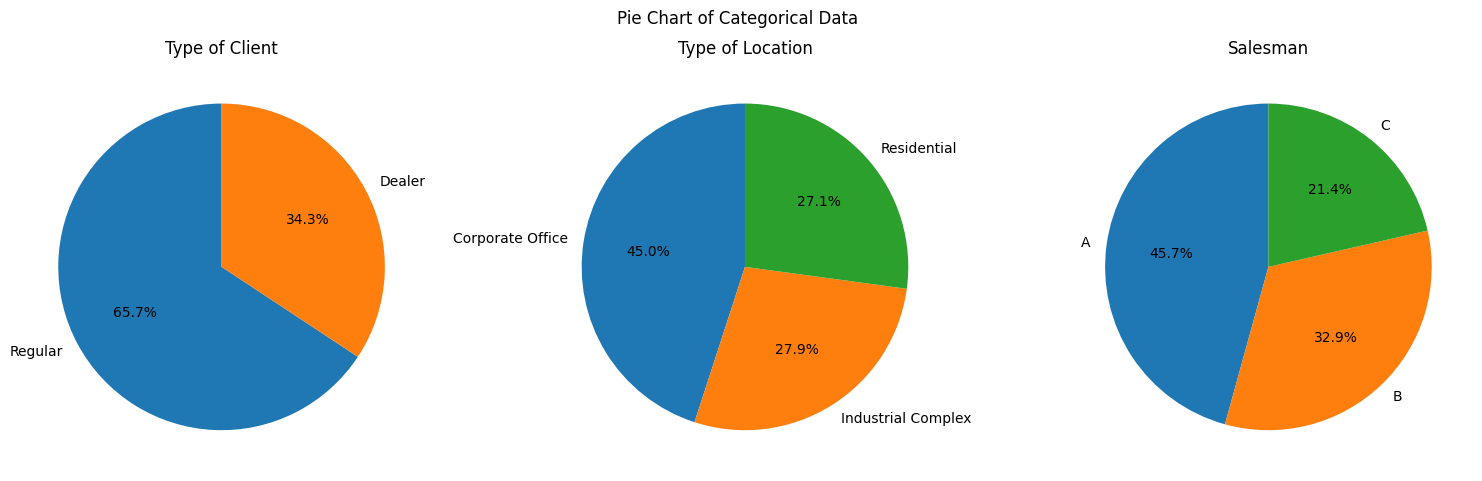

In [16]:
#Pie Chart for Categorical Data
client_type_count = df['Type of Client'].value_counts()
location_type_count = df['Type of Location'].value_counts()
salesman_count = df['Salesman'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].pie(client_type_count, labels=client_type_count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Type of Client')

axs[1].pie(location_type_count, labels=location_type_count.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Type of Location')

axs[2].pie(salesman_count, labels=salesman_count.index, autopct='%1.1f%%',startangle=90)
axs[2].set_title('Salesman')

fig.suptitle('Pie Chart of Categorical Data')
plt.tight_layout()
plt.show()

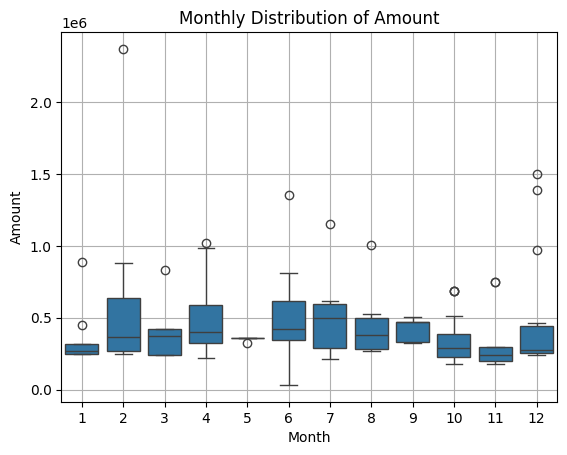

In [17]:
sns.boxplot(x=month, y=amount, data=df)
plt.title('Monthly Distribution of Amount')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.grid(True)
plt.show()

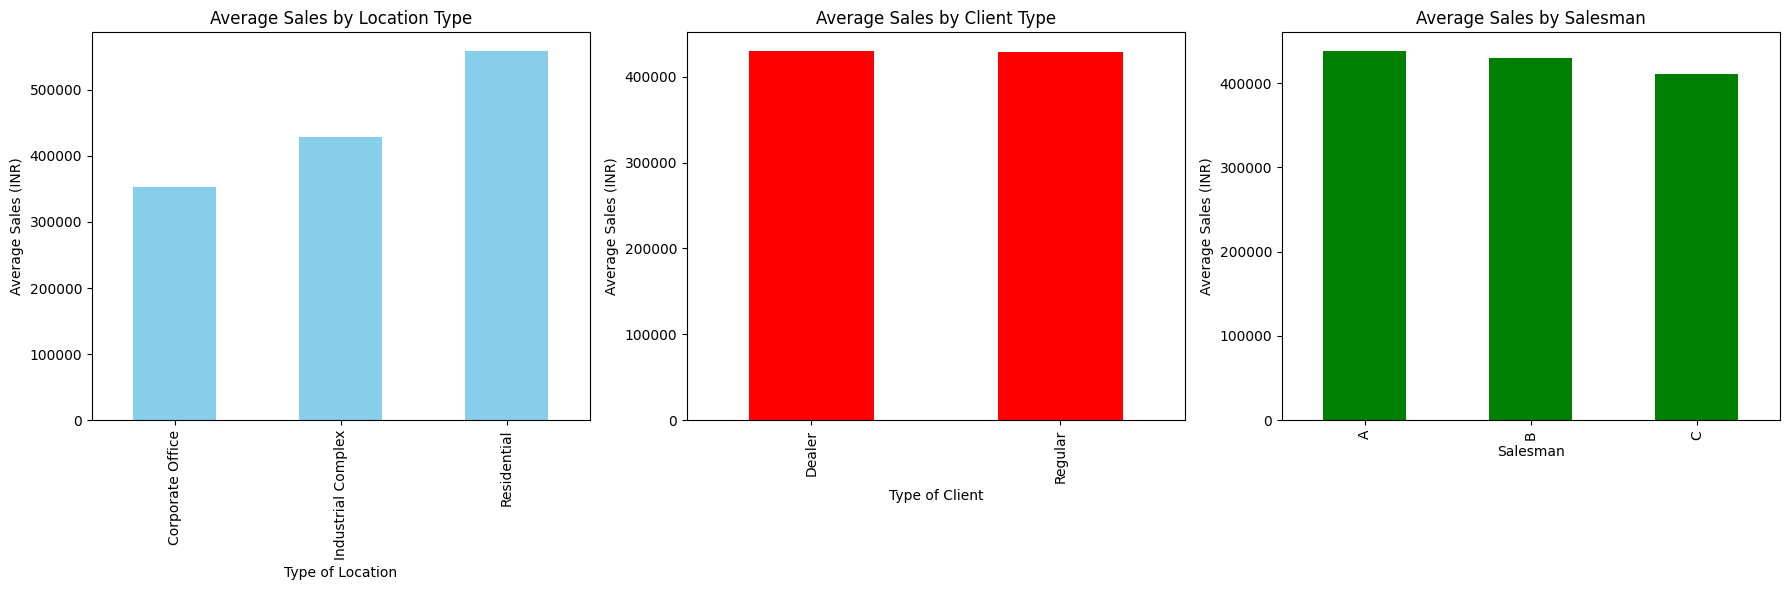

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
client_location_stats = df.groupby('Type of Location')['Amount'].mean()
client_location_stats.plot(
    kind='bar',
    ax=axes[0],
    title='Average Sales by Location Type',
    color='skyblue'
)

axes[0].set_xlabel('Type of Location')
axes[0].set_ylabel('Average Sales (INR)')
client_type_stats = df.groupby('Type of Client')['Amount'].mean()
client_type_stats.plot(
    kind='bar',
    ax=axes[1],
    title='Average Sales by Client Type',
    color='red'
)

axes[1].set_xlabel('Type of Client')
axes[1].set_ylabel('Average Sales (INR)')
salesman_stats = df.groupby('Salesman')['Amount'].mean()
salesman_stats.plot(
    kind='bar',
    ax=axes[2],
    title='Average Sales by Salesman',
    color='green'
)
axes[2].set_xlabel('Salesman')
axes[2].set_ylabel('Average Sales (INR)')
# Adjust layout and display
plt.tight_layout()
plt.show()

In [48]:
# Convert 'Date' column to datetime and extract Month/Year
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Extract numeric part from Rating (e.g., "125kVA" -> 125.0)
df['Rating_kVA'] = df['Rating'].str.extract(r'(\d+\.?\d*)').astype(float)

# Calculate average amount by Rating
rating_avg = df.groupby('Rating')['Amount'].mean()
df['Rating_Avg_Amount'] = df['Rating'].map(rating_avg)

# Define Success as sales amount above median for that Rating
rating_median = df.groupby('Rating')['Amount'].transform('median')
df['Success'] = (df['Amount'] > rating_median).astype(int)

In [49]:
# Create new feature: Amount per kVA
df['Amount_per_kVA'] = df['Amount'] / df['Rating_kVA']

# Binary flag if client is a Dealer
df['Is_Dealer'] = (df['Type of Client'] == 'Dealer').astype(int)

# Binary flag for end of financial quarters (March, June, Sep, Dec)
df['Is_Quarter_End'] = df['Month'].isin([3, 6, 9, 12]).astype(int)

# Ratio of this sale to average sale in same location
location_avg = df.groupby('Location')['Amount'].transform('mean')
df['Location_Amount_Ratio'] = df['Amount'] / location_avg

### Description
This function, engineer_features(data), performs feature engineering to create new columns
that enhance the dataset for better model performance:
1. New Features:
• Amount_per_kVA: Calculates the transaction amount per unit of generator rating in kVA.
Helps assess value efficiency for each transaction.
• Is_Dealer: A binary feature indicating whether the client is a dealer (1) or not (0).
2. Seasonal Features:
• Is_Quarter_End: A binary feature indicating whether the transaction occurred during
the end of a financial quarter (March, June, September, December).
3. Location-Based Features:
• Location_Amount_Ratio: Computes the ratio of the transaction amount to the average
transaction amount for that location. This normalizes transactions relative to the typical
sales volume at each location.
These features provide deeper insights into client behavior, seasonal patterns, and regional differences, potentially improving the performance of predictive models.

In [53]:

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Identify categorical and numerical features
cat_features = ['Type of Location', 'Location', 'Salesman', 'Type of Client']
num_features = ['Rating_kVA', 'Month', 'Rating_Avg_Amount', 'Amount_per_kVA', 'Location_Amount_Ratio']

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# Prepare training and test data
X = df[cat_features + num_features]
y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Store results
results = []

for name, model in models.items():
    # Create pipeline for each model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for ROC AUC
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Cross-validation
    cv_score = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()
    
    results.append({
        'Model': name,
        'ROC-AUC (Test)': round(auc_score, 4),
        'Cross-Validation ROC-AUC': round(cv_score, 4)
    })

# Display all model results
results_df = pd.DataFrame(results).sort_values('Cross-Validation ROC-AUC', ascending=False)
print("\n📊 Model Comparison Results:")
print(results_df.to_string(index=False))



📊 Model Comparison Results:
              Model  ROC-AUC (Test)  Cross-Validation ROC-AUC
      Random Forest          0.6952                    0.7663
  Gradient Boosting          0.7326                    0.7138
Logistic Regression          0.5508                    0.5839
K-Nearest Neighbors          0.5348                    0.5592


### Description
This function, train_and_evaluate_model(data, test_size=0.2, random_state=42), builds,
trains, and evaluates a classification model using a combination of categorical and numerical features. Here’s a detailed breakdown:
1. Feature Selection:
• Categorical Features: Type of Location, Location, Salesman, and Type of
Client are selected for one-hot encoding.
• Numerical Features: Includes Rating_kVA, Month, Rating_Avg_Amount,
Amount_per_kVA, and Location_Amount_Ratio, which are scaled for uniformity.
2. Data Splitting:
• The dataset is split into training and testing subsets using an 80-20 ratio
(test_size=0.2).
• Stratified sampling is applied to preserve class distribution in y.
3. Preprocessing Pipeline:
• Categorical Transformer: Uses OneHotEncoder to handle categorical data, ignoring
unknown categories.
• Numerical Transformer: Uses StandardScaler to normalize numerical features.
• Combines transformations using ColumnTransformer.
4. Model Pipeline:
• Combines the preprocessing steps with a RandomForestClassifier for classification.
• The classifier is initialized with 100 estimators and a maximum depth of 10 for simplicity
and control over overfitting.
8
5. Training and Predictions:
• The pipeline is trained on the training dataset.
• Predictions (y_pred) and probabilities (y_prob) are generated on the test dataset.
6. Evaluation Metrics:
• Cross-Validation Scores: Uses 5-fold cross-validation to evaluate the model’s consistency across splits.
• Classification Report: Provides precision, recall, F1-score, and support for each class.
• ROC-AUC Score: Measures the model’s ability to distinguish between classes, with a
higher score indicating better performance.
7. Output:
• The trained pipeline, classification report, ROC-AUC score, and cross-validation scores
are returned for further analysis.
This function provides a streamlined approach to train and evaluate a classification model with
preprocessing, ensuring both numerical and categorical features are handled appropriately.


### Description
This function, plot_feature_importance(pipeline, feature_names), visualizes the importance
of features used in the RandomForestClassifier within the trained pipeline. Here’s the breakdown:
1. Accessing the Model and Preprocessor:
• Retrieves the trained RandomForestClassifier from the pipeline using
pipeline.named_steps['classifier'].
• Retrieves the ColumnTransformer (preprocessor) from the pipeline.
2. Extracting Feature Names:
9
• Categorical Features: Extracts feature names after one-hot encoding using
get_feature_names_out().
• Numerical Features: Extracts the original numerical feature names from the preprocessor.
• Combines both categorical and numerical feature names into a single list
(all_features).
3. Calculating Feature Importance:
• Retrieves feature importance scores from the RandomForestClassifier using the
feature_importances_ attribute.
• Pairs the feature names with their importance scores.
4. Creating a DataFrame for Visualization:
• Creates a DataFrame with two columns: feature (feature names) and importance
(importance scores).
• Sorts the DataFrame by importance in descending order to identify the most significant
features.
5. Visualization:
• Plots the top 15 most important features using a horizontal bar plot:
– x-axis: Importance scores.
– y-axis: Feature names.
• Sets appropriate titles and labels for the plot for better interpretability.
• Adjusts the layout for a clean display.
6. Output:
• A bar chart showing the top 15 most important features, enabling quick identification
of the key contributors to the model’s predictions.
This visualization helps in understanding which features have the highest influence on the model,
providing insights into the dataset and aiding in feature selection or refinement.

In [52]:
# Sample new data point
example = pd.DataFrame({
    'Type of Location': ['Industrial Complex'],
    'Location': ['Noida'],
    'Salesman': ['A'],
    'Type of Client': ['Regular'],
    'Rating_kVA': [500],
    'Month': [6],
    'Rating_Avg_Amount': [400000],
    'Amount_per_kVA': [800],
    'Location_Amount_Ratio': [1.2]
})

# Predict success probability
predicted_prob = pipeline.predict_proba(example)[0][1]
print(f"\n🔮 Predicted Success Probability: {predicted_prob:.4f}")



🔮 Predicted Success Probability: 0.1831


### Description
The function predict_sale_success(pipeline, new_data) uses a trained pipeline to predict the
probability of success for new sales opportunities. Here’s how it works:
1. Purpose:
• Predicts the likelihood of a sale being successful, which can be useful for decision-making
in sales strategies.
10
2. Parameters:
• pipeline: The trained machine learning pipeline, including preprocessing and the classification model.
• new_data: A DataFrame containing the new sales data with all required features for
prediction.
3. Workflow:
• Uses the predict_proba method of the trained pipeline’s classifier to calculate the class
probabilities for each input record.
• Extracts the probability of the positive class (1) using [:, 1].
4. Output:
• Returns an array containing the probabilities of success for each record in the new_data.
5. Usage:
• This function is designed to work seamlessly with the trained pipeline and expects
new_data to have the same structure (features) as the training data.
• The returned probabilities can be used for further analysis, decision thresholds, or ranking potential sales opportunities.
By providing success probabilities, this function supports data-driven approaches to prioritize and
focus on sales opportunities with higher chances of success.